# Likelihood computation

### Signal in frequency domain:
Signal parameters: $\ \vec{\theta} \equiv \{D,m_1,m_2,\chi_{eff},\iota,\psi,\phi_0,t_c,\theta,\phi\} \\ $
\begin{equation*}
\tilde{h}(f,\vec{\theta}) ~=~ F_+(\theta,\phi,\psi) ~\frac{1+\cos^2 \iota}{2}~ \tilde{h}_+(f,m_1,m_2,\chi_{eff},D,\phi_0,t_c) ~+~ F_\times(\theta,\phi,\psi) ~\cos \iota ~\tilde{h}_\times(f,m_1,m_2,\chi_{eff},D,\phi_0,t_c)\tag{1}
\end{equation*}

For non-precessing systems: $\ \tilde h_+ = -i h_\times \equiv \frac{1}{D} h_0(f)~e^{2\pi ift_c+\phi_0}$

\begin{eqnarray}
\implies~\tilde{h}(f,\vec{\theta}) ~&=&~ \frac{ ~e^{i \phi_0}}{D} \left[~ F_+(\theta,\phi,\psi) ~\frac{1+\cos^2 \iota}{2} ~-~i F_\times(\theta,\phi,\psi) ~\cos \iota ~\right] ~~ \tilde h_0(f,m_1,m_2,\chi_{eff}) ~e^{2\pi ift_c} \\
&\equiv& A(D,\theta,\phi,\phi_0) ~~ \tilde h_0(f,m_1,m_2,\chi_{eff})~e^{2\pi ift_c} \tag{2}
\end{eqnarray} 

### Likelihood of data $d$ with filter $h(\vec{\theta})$:
\begin{equation*}
\ln \mathcal{L}(d|\vec{\theta}) ~=~ (d~|~h(\vec{\theta})) -\frac{1}{2} \left[ (h(\vec{\theta})~|~h(\vec{\theta})) + (d~|~d) \right] \tag{3}
\end{equation*}

Here

\begin{eqnarray} 
(h(\vec{\theta})~|~h(\vec{\theta}))  &=& \left|A(D,\theta,\phi,\phi_0)\right|^2 ~\left.\left(h_0(m_1,m_2,\chi_{eff})~\right|~h_0(m_1,m_2,\chi_{eff})\right) \tag{4} \\
(d~|~h(\vec{\theta})) &=& \Re ~A(D,\theta,\phi,\phi_0)~~ z\left(d,h_0(m_1,m_2,\chi_{eff}),t\right) \tag{5}
\end{eqnarray} 

with
\begin{equation*}
z\left(d,h,t\right) =4 \int \frac{\tilde d(f) \tilde h^*(f)}{Sn(f)}~e^{-2\pi i f t} df \tag{6}
\end{equation*}


In [336]:
import generate_fake_ligosignal as sig
import numpy as np
import matplotlib.pyplot as plt, mpld3
from pycbc import types, fft, waveform
import pycbc
from pycbc.filter import match
#from xml.dom import minidom

In [337]:
def generate_noise(params):
    
    delta_f = 1./params['tlen']
    flen = int(params['fsamp_psd'] / delta_f) + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, params['flow'])
    
    delta_t = 1.0 / params['fsamp_noise']
    tsamples = int(params['tlen'] / delta_t)

    n = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)
    ntilde = n.to_frequencyseries()
    
    return psd, n, ntilde

def generate_fdsignal(params):
    
    hp, hc = pycbc.waveform.get_fd_waveform(approximant = params['approximant'],mass1=params['mass1'], mass2=params['mass2'], spin1z=params['spin1z'], spin2z=params['spin2z'], 
                                                distance=params['distance'], coa_phase=params['coa_phase'], f_lower=params['flow'], delta_f=1./params['tlen'], amplitude_order=params['amplitude_order'])
        
    return hp, hc

def generate_fddata(ifo, hp, hc, ntilde, params):
    
    detector = pycbc.detector.Detector(ifo)
    fp,fc = detector.antenna_pattern(params['ra'], params['dec'], params['psi'], params['tgps'])  #Antenna pattern
    freq = hp.get_sample_frequencies().data      # Frequency vector
    shift  = types.FrequencySeries(np.exp(-2j*np.pi*freq*params['tc']),delta_f=1./params['tlen'])   #Time shift
    signal = ( fp*(1 + np.cos(params['iota'])**2)/2 * hp + fc*np.cos(params['iota']) * hc )* shift   # Adding Time shift in the signal
    signal_new = ( fp*(1 + np.cos(params['iota'])**2)/2 * hp + fc*np.cos(params['iota']) * hc )
    
    signal.resize(len(ntilde))
    signal_new.resize(len(ntilde))
    data = ntilde + signal
    data_new = ntilde + signal_new
    
    return fp, fc, shift, signal, signal_new, data, data_new

def pad_with(vector, pad_width, iaxis, kwargs):  
    padding_value_1, padding_value_2  = np.zeros(pad_width[0]), 2048.0
    for i in range(pad_width[0]-1):
        padding_value_1[i+1] = padding_value_1[i] + 0.03125
    vector[:pad_width[0]] = padding_value_1
    vector[-pad_width[1]:] = padding_value_2
    return vector

def calculate_logL(h0, psd, data, A, flow):
    
    #(h0|h0)
    h0_h0 = pycbc.filter.sigmasq(h0, psd=psd, low_frequency_cutoff=flow)
    h_h = A*A.conj() * h0_h0
    #(d|d)
    d_d = pycbc.filter.sigmasq(data, psd=psd, low_frequency_cutoff=flow) 

    #complex SNR time series, z(\hat{h0},d)
    z =  pycbc.filter.matched_filter(h0, data, psd=psd,
                                      low_frequency_cutoff=flow) 
    d_h = np.real(np.sqrt(h0_h0) * A * z.data)
    ln_L = types.TimeSeries(d_h - 0.5 * (d_d + h_h), delta_t=z.delta_t)
    snr_mf = max(abs(z))
    
    return h_h, d_d, d_h, ln_L, z, snr_mf 


def generate_filter(ifo, ntilde, params):
    
    detector = pycbc.detector.Detector(ifo)
    hp, hc = pycbc.waveform.get_fd_waveform(approximant = params['approximant'],mass1=params['mass1'], mass2=params['mass2'], spin1z=params['spin1z'], spin2z=params['spin2z'], 
                                                distance=params['distance'], coa_phase=params['coa_phase'], f_lower=params['flow'], delta_f=ntilde.delta_f, amplitude_order=params['amplitude_order'])
    fp,fc = detector.antenna_pattern(params['ra'], params['dec'], params['psi'], params['tgps'])  #Antenna pattern
    A = np.exp(1j*params['phi0'])/params['distance'] * ( fp*(1+np.cos(params['iota'])**2)/2 - 1j*fc*np.cos(params['iota']) )
    
    hp.resize(len(ntilde))
    return hp, A

def invfft(delta_t, hp):
    
    tlen = int(1./delta_t / hp.delta_f)
    hp.resize(tlen/2 + 1)
    hp_td = types.TimeSeries(types.zeros(tlen), delta_t=hp.delta_t)
    fft.ifft(hp, hp_td)

    return hp_td

In [338]:
params_signal = { 'tlen' : 32.,
        'fsamp_noise' : 4096.,
        'flow' : 10., 
        'approximant' : "IMRPhenomD", 
        'mass1' : 20.,
        'mass2' : 20.,
        'spin1z' : 0.,
        'spin2z' : 0.,
        'distance' : 400.,
        'coa_phase' : 0.,
        'iota' : np.pi/4,
        'psi' : 0.,
        'ra' : 1.501034,
        'dec': np.pi/4,
        'tc' : 30.,
        'tgps' : 1126258000.,
        'amplitude_order' : 0.
         }

params_noise = { 'tlen' : 32.,
        'fsamp_psd' : 2048.,
        'fsamp_noise' : 4096.,
        'flow' : 10.,
        }

params_tmpl = { 
        'tlen' : 32.,
        'flow' : 10., 
        'approximant' : "IMRPhenomD", 
        'mass1' : 20.,
        'mass2' : 20.,
        'spin1z' : 0.,
        'spin2z' : 0.,
        'distance' : 400.,
        'coa_phase' : 0.,
        'phi0' : 0.,
        'iota' : np.pi/4,
        'psi' : 0.,
        'ra' : 1.501034,
        'dec': np.pi/4,
        'tgps' : 1126258000.,
        'amplitude_order' : 0.
         }

##################################### data generation using PyCBC ####################################

psd, n, ntilde = generate_noise(params_noise)
hp, hc = generate_fdsignal(params_signal)
fp, fc, shift, signal, signal_new, data, data_new = generate_fddata('L1', hp, hc, ntilde, params_signal)
h0, A = sig.generate_filter('L1', ntilde, params_tmpl)

################################### data generation using LaLInference ###############################

f_sig, signal_real, signal_imag = np.loadtxt('injection_L1.dat', unpack=True, usecols=[0,1,2])                  # loading the injected signal
psd_inj = np.loadtxt('lalinferencenest-0-V1H1L1-1126258000.0-0.hdf5L1-PSD.dat', unpack=True, usecols=[1])           # loading the injected psd
psd_inj = types.FrequencySeries(psd, 0.03125)

delta_t = 1.0 / 4096
tsamples = int(32. / delta_t)
n_inj = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)
ntilde_inj = n_inj.to_frequencyseries()

f_sig_mod = np.pad(f_sig, (320,1), pad_with)  
signal_real_mod, signal_imag_mod = np.pad(signal_real, (320,1), 'constant', constant_values=(0,0)), np.pad(signal_imag, (320,1), 'constant', constant_values=(0,0))

signal_inj = signal_real_mod + signal_imag_mod*1j
signal_inj = types.FrequencySeries(signal_inj, 0.03125)

data_inj = signal_inj + ntilde_inj

############## log-likelihood calculation #############################

flow = 10
h_h_py, d_d_py, d_h_py, ln_L, z_py, snr_mf_py  = calculate_logL(h0, psd, data, A, flow)
h_h_inj, d_d_inj, d_h_inj, ln_L_inj, z_inj, snr_mf_inj  = calculate_logL(h0, psd_inj, data_inj, A, flow)

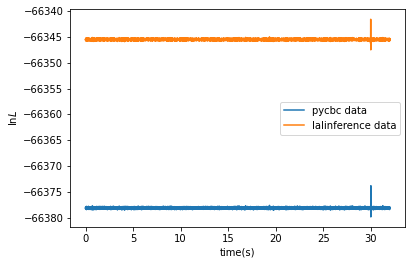

In [340]:
plt.plot(ln_L.sample_times, ln_L.real(), label='pycbc data')
plt.plot(ln_L_inj.sample_times, ln_L_inj.real(), label='lalinference data')

plt.xlabel('time(s)')
plt.ylabel(r'$\ln L$')
plt.legend()
plt.show()

In [341]:
delta_t = 1./4096.
signal_td, signal_td_inj = invfft(delta_t, signal), invfft(delta_t, signal_inj)

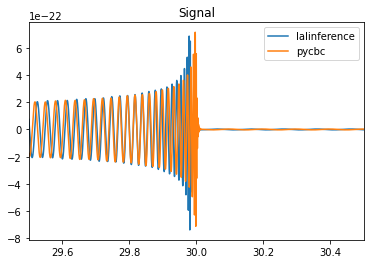

In [349]:
plt.plot(signal_td_inj.sample_times, signal_td_inj, label='lalinference')
plt.plot(signal_td_inj.sample_times, signal_td, label='pycbc')

plt.legend()
plt.xlim(29.5,30.5)
plt.title('Signal')
plt.show()

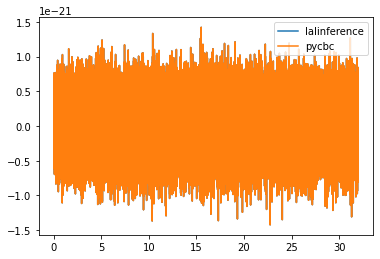

In [343]:
plt.plot(n_inj.sample_times, n_inj, label='lalinference')
plt.plot(n_inj.sample_times, n, label='pycbc')

plt.legend()
#plt.xlim(29.5,30.5)
plt.show()

In [353]:
def whiten(strain, psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(psd /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

In [355]:
n_wt, n_wt_inj = whiten(n, psd, 1.0/4096.), whiten(n_inj, psd_inj, 1.0/4096.)

In [352]:
help(types.TimeSeries.whiten)

Help on function whiten in module pycbc.types.timeseries:

whiten(self, segment_duration, max_filter_duration, trunc_method='hann', remove_corrupted=True, low_frequency_cutoff=None, return_psd=False, **kwds)
    Return a whitened time series
    
    Parameters
    ----------
    segment_duration: float
        Duration in seconds to use for each sample of the spectrum.
    max_filter_duration : int
        Maximum length of the time-domain filter in seconds.
    trunc_method : {None, 'hann'}
        Function used for truncating the time-domain filter.
        None produces a hard truncation at `max_filter_len`.
    remove_corrupted : {True, boolean}
        If True, the region of the time series corrupted by the whitening
        is excised before returning. If false, the corrupted regions
        are not excised and the full time series is returned.
    low_frequency_cutoff : {None, float}
        Low frequency cutoff to pass to the inverse spectrum truncation.
        This should be

In [326]:
t = signal_td_inj.sample_times
signal_td, signal_td_inj = np.array(signal_td), np.array(signal_td_inj)
n, n_inj = np.array(n), np.array(n_inj)

signal_td = TimeSeries()

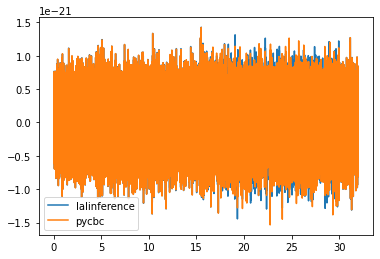

In [334]:
plt.plot(t, signal_td_inj+n_inj, label='lalinference')
plt.plot(t, signal_td+n, label='pycbc')

plt.legend()
#plt.xlim(29.5,30.5)
plt.show()

In [ ]:
d